In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(os.path.join('data', 'jena_climate_2009_2016.csv'))

In [3]:
# 提取溫度數據（在數據集中的'T (degC)'列）
temperature = data['T (degC)'].values

In [4]:
# 資料正規化
scaler = MinMaxScaler()
# np.expand_dims(temperature, 1)
temperature = scaler.fit_transform(temperature.reshape(-1, 1)) # row ? * col 1
temperature.shape

(420451, 1)

In [5]:
def create_time_series(data, time_steps):
    X, y = [], []
    l = 0
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [6]:
# 超參數
time_steps = 24  # 時間步長，例如，過去24小時的數據用於預測未來的溫度
batch_size = 64
epochs = 10

In [7]:
# 創建時間序列數據
X, y = create_time_series(temperature, time_steps)

In [8]:
# 分割數據集為訓練集和測試集
train_ratio = 0.6  # 訓練集佔總數據的比例
validation_ratio = 0.2  # 驗證集佔總數據的比例
test_ratio = 0.2  # 測試集佔總數據的比例

train_index = int(train_ratio * len(X))
validation_index = int((train_ratio + validation_ratio) * len(X))

X_train, X_val, X_test = X[:train_index], X[train_index:validation_index], X[validation_index:]
y_train, y_val, y_test = y[:train_index], y[train_index:validation_index], y[validation_index:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, 

((252256, 24, 1),
 (252256, 1),
 (84085, 24, 1),
 (84085, 1),
 (84086, 24, 1),
 (84086, 1))

In [ ]:
# # 分割數據集為訓練集和測試集
# split_ratio = 0.8
# split_index = int(split_ratio * len(X))
# X_train, X_test = X[:split_index], X[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [9]:
# 建立LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [10]:
logs_dir = 'logs'
# log callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [12]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/lstm_temperature_pred.h5',  
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [13]:
# 訓練模型
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback, early_stopping_callback, model_checkpoint_callback]
)

Epoch 1/10
3935/3942 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 1: val_loss improved from inf to 0.00003, saving model to ./models/lstm_temperature_pred.h5
3942/3942 [==============================] - 27s 7ms/step - loss: 0.0024 - val_loss: 3.4371e-05
Epoch 2/10
3938/3942 [============================>.] - ETA: 0s - loss: 3.2599e-05
Epoch 2: val_loss improved from 0.00003 to 0.00003, saving model to ./models/lstm_temperature_pred.h5
3942/3942 [==============================] - 25s 6ms/step - loss: 3.2595e-05 - val_loss: 3.2992e-05
Epoch 3/10
3939/3942 [============================>.] - ETA: 0s - loss: 2.2709e-05
Epoch 3: val_loss improved from 0.00003 to 0.00002, saving model to ./models/lstm_temperature_pred.h5
3942/3942 [==============================] - 25s 6ms/step - loss: 2.2707e-05 - val_loss: 1.7315e-05
Epoch 4/10
3938/3942 [============================>.] - ETA: 0s - loss: 1.6473e-05
Epoch 4: val_loss improved from 0.00002 to 0.00001, saving model to ./mode

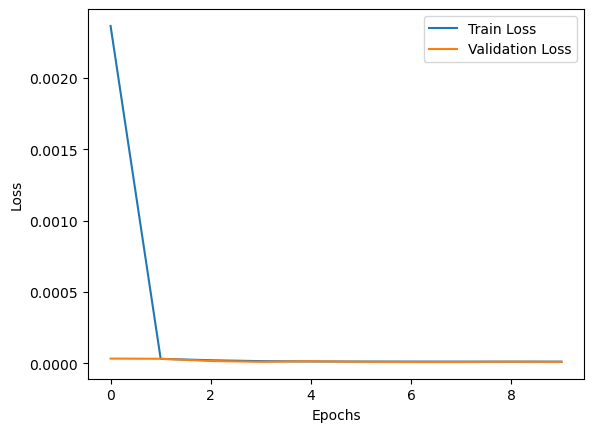

In [16]:
# 繪製訓練過程的損失曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [17]:
# 使用模型預測
y_pred = model.predict(X_test)

2628/2628 [==============================] - 3s 1ms/step


In [18]:
# 將預測的溫度數據反歸一化
y_pred_inversed = scaler.inverse_transform(y_pred)
y_test_inversed = scaler.inverse_transform(y_test)

y_pred_inversed, y_test_inversed

(array([[11.537964 ],
        [11.625618 ],
        [11.548191 ],
        ...,
        [-3.0450816],
        [-3.125804 ],
        [-4.624295 ]], dtype=float32),
 array([[11.56],
        [11.54],
        [11.63],
        ...,
        [-3.16],
        [-4.23],
        [-4.82]]))

In [19]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_inversed, y_pred_inversed)
mse

0.04352805876473669

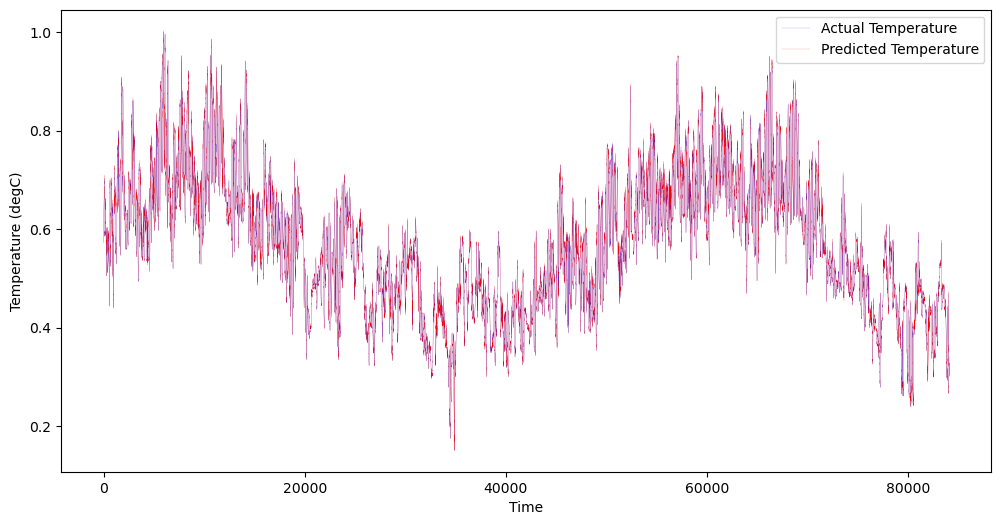

In [24]:
# 繪製實際溫度和預測溫度的比較圖
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Temperature', color='blue', linewidth=.1)
plt.plot(y_pred, label='Predicted Temperature', color='red', linewidth=.1)
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

In [ ]:
# model.save(os.path.join('models', 'lstm_temperature_pred.h5'))